<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0711.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_100_acc(y_true, y_pred):
    delta = 100
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_300_acc(y_true, y_pred):
    delta = 300
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))
 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

In [5]:
per_meter_mapping = {
    'Mercaz': 500,
    'Old North': 350,
    'Florentine': 230
}

per_room_additional_price = {
    'Mercaz': 15. * 10**4,
    'Old North': 8. * 10**4,
    'Florentine': 5. * 10**4
}

per_type_price = {
    'fullsize': 3,
    'economy': 1.2,
    'convertible': 9,
    'standard': 2.5,
    'premium': 4,
    'intermediate': 2,
    'luxury': 12,
    'compact': 1.5
}

def house_price_func(row):
    """
    house_price_func is the function f(a,s,n).
    
    :param row: dict (contains the keys: ['area', 'size', 'n_rooms'])
    :return: float
    """
    date, area, size, n_rooms, ctype = row['date'], row['area'], row['size'], row['n_rooms'], row['ctype']
    rate = 1
    if date >= datetime.date(2010,4,18):
      rate = 0.90
    if date >= datetime.date(2010,4,22):
      rate = 0.46    
    if date >= datetime.date(2010,5,10):
      rate = 0.80
    if date >= datetime.date(2010,5,14):
      rate = 0.95
    if date >= datetime.date(2010,5,20):
      rate = 0.88
    if date >= datetime.date(2010,5,22):
      rate = 0.65
    if date >= datetime.date(2010,6,1):
      rate = 1.00
    if date >= datetime.date(2010,6,5):
      rate = 0.81


    return (size * per_meter_mapping[area] - 120)*rate + (n_rooms*n_rooms)/4 * per_room_additional_price[area] * per_type_price[ctype]

In [6]:
AREAS = ['Mercaz', 'Old North', 'Florentine']
HOUSE_TYPE = ['economy','compact','intermediate','standard','fullsize','premium','luxury','convertible']

def create_samples(n_samples):
    """
    Helper method that creates dataset DataFrames
    
    Note that the np.random.choice call only determines the number of rooms and the size of the house
    (the price, which we calculate later, is deterministic)
    
    :param n_samples: int (number of samples for each area (suburb))
    :return: pd.DataFrame
    """
    d = datetime.date(2010, 4, 13)
    samples = []

    for i in range(n_samples):
        if random.choices(range(120)) == [1]:
          d += datetime.timedelta(days=1)
        samples.append([d, np.random.choice(AREAS), int(np.random.normal(25, 5)),int(np.random.normal(300, 50)), np.random.choice(range(1, 6)),np.random.choice(HOUSE_TYPE)])
        
    return pd.DataFrame(samples, columns=['date','area', 'size', 'lamp', 'n_rooms','ctype'])

In [7]:
dataset = create_samples(n_samples=30000)
dataset['price'] = dataset.apply(house_price_func, axis=1)

In [8]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
date,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,2010-05-21,852
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,int64,30000,0,24.4527,5.00853,5,21,24,28,46,NaN,NaN,NaN
lamp,int64,30000,0,299.045,50.0219,116,265,299,333,525,NaN,NaN,NaN
n_rooms,int64,30000,0,2.9991,1.41203,1,2,3,4,5,NaN,NaN,NaN
ctype,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,intermediate,3852
price,float64,30000,0,1.13951e+06,1.717e+06,16020.6,174436,502696,1.35419e+06,1.12659e+07,NaN,NaN,NaN


In [9]:
# dataset의 파생변수 생성

dataset['size_n_rooms'] = dataset['size'] * dataset['n_rooms']
dataset['size_size'] = dataset['size'] * dataset['size']
dataset['n_rooms_n_rooms'] = dataset['n_rooms'] * dataset['n_rooms']

In [10]:
# zscore norm

ds = dataset[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,date,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms
0,2010-04-13,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094
1,2010-04-13,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840
2,2010-04-13,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840
3,2010-04-13,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149
4,2010-04-13,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900
...,...,...,...,...,...,...,...,...,...,...
29995,2010-12-19,Old North,1.107578,0.678800,0.708837,intermediate,648407.8,1.212522,1.118778,0.580094
29996,2010-12-19,Florentine,-0.090379,0.978669,-1.415762,intermediate,29374.0,-1.286119,-0.189911,-1.156149
29997,2010-12-19,Florentine,0.708259,0.998660,0.708837,standard,505119.2,1.004302,0.650235,0.580094
29998,2010-12-19,Florentine,2.505195,-0.560658,0.708837,fullsize,606795.9,1.941292,3.013147,0.580094


In [11]:
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [12]:
area_mapping = EmbeddingMapping(dataset['area'])
type_mapping = EmbeddingMapping(dataset['ctype'])
date_mapping = EmbeddingMapping(dataset['date'])

dataset = dataset.assign(area_mapping=dataset['area'].apply(area_mapping.get_mapping))
dataset = dataset.assign(type_mapping=dataset['ctype'].apply(type_mapping.get_mapping))
dataset = dataset.assign(date_mapping=dataset['date'].apply(date_mapping.get_mapping))
dataset

,date,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,date_mapping
0,2010-04-13,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094,1,1,1
1,2010-04-13,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840,2,2,1
2,2010-04-13,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840,1,2,1
3,2010-04-13,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149,2,3,1
4,2010-04-13,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2010-12-19,Old North,1.107578,0.678800,0.708837,intermediate,648407.8,1.212522,1.118778,0.580094,2,5,251
29996,2010-12-19,Florentine,-0.090379,0.978669,-1.415762,intermediate,29374.0,-1.286119,-0.189911,-1.156149,1,5,251
29997,2010-12-19,Florentine,0.708259,0.998660,0.708837,standard,505119.2,1.004302,0.650235,0.580094,1,3,251
29998,2010-12-19,Florentine,2.505195,-0.560658,0.708837,fullsize,606795.9,1.941292,3.013147,0.580094,1,4,251


In [13]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms','area_mapping','type_mapping','date_mapping']],
    dataset['price'], test_size=0.1, random_state=0)


X_train_continuous_org = X_train_org[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]
X_train_categorical_org = X_train_org[['area_mapping','type_mapping']]
X_train_date_org = X_train_org[['date_mapping']]

X_val_continuous_org = X_val_org[['size','lamp','n_rooms','size_n_rooms','size_size','n_rooms_n_rooms']]
X_val_categorical_org = X_val_org[['area_mapping','type_mapping']]
X_val_date_org = X_val_org[['date_mapping']]

# 학습 대상 변수만 선택
X_train_continuous = X_train_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_train_categorical = X_train_categorical_org
X_train_date = X_train_date_org

X_val_continuous  = X_val_continuous_org[['size','n_rooms','n_rooms_n_rooms']]
X_val_categorical = X_val_categorical_org
X_val_date = X_val_date_org

In [14]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=25)(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)


In [15]:
date_input = Input(shape=(1,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3
# Let’s define the embedding layer and flatten it

date_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_date['date_mapping'].max()+1)(date_input)
date_embedings = keras.layers.Reshape((embeddings_output*1,))(date_embedings)

In [16]:
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings, date_embedings])
print(all_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 219), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [20]:
# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input, date_input], outputs=predictions)
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2, 72)        1800        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 72)        18144       ['input_2[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [21]:
X_train_categorical

,area_mapping,type_mapping
5179,3,2
12341,3,8
13458,2,6
24069,2,1
28240,3,1
...,...,...
13123,1,7
19648,2,5
9845,3,3
10799,3,4


In [22]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical,X_train_date], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical,X_val_date], Y_val))

Epoch: 50 - {'loss': 4234077011968.0, 'soft_100_acc': 0.0, 'soft_300_acc': 0.0, 'r2': -0.4714394509792328, 'val_loss': 4313988988928.0, 'val_soft_100_acc': 0.0, 'val_soft_300_acc': 0.0, 'val_r2': -0.44801533222198486}
Epoch: 100 - {'loss': 4232899985408.0, 'soft_100_acc': 0.0, 'soft_300_acc': 0.0, 'r2': -0.4692903161048889, 'val_loss': 4312833720320.0, 'val_soft_100_acc': 0.0, 'val_soft_300_acc': 0.0, 'val_r2': -0.447599858045578}


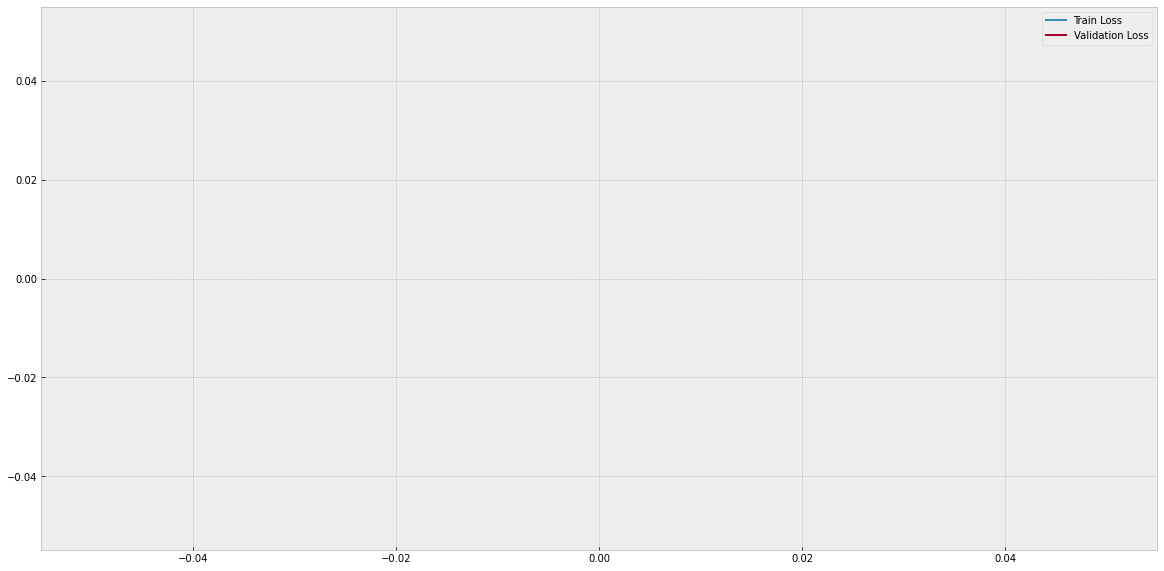

In [23]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1126946
            price         pred  ...      %diff  abs_%diff
637    11265880.0  2451.759033  ... -99.978237  99.978237
7849   11264380.0  2451.759033  ... -99.978234  99.978234
29892  11262862.8  2451.759033  ... -99.978231  99.978231
19070  11262457.8  2451.759033  ... -99.978231  99.978231
15384  11262052.8  2451.759033  ... -99.978230  99.978230

[5 rows x 6 columns]
The mean is very close to 0 (-1124494.48) with std. 1746242.61.


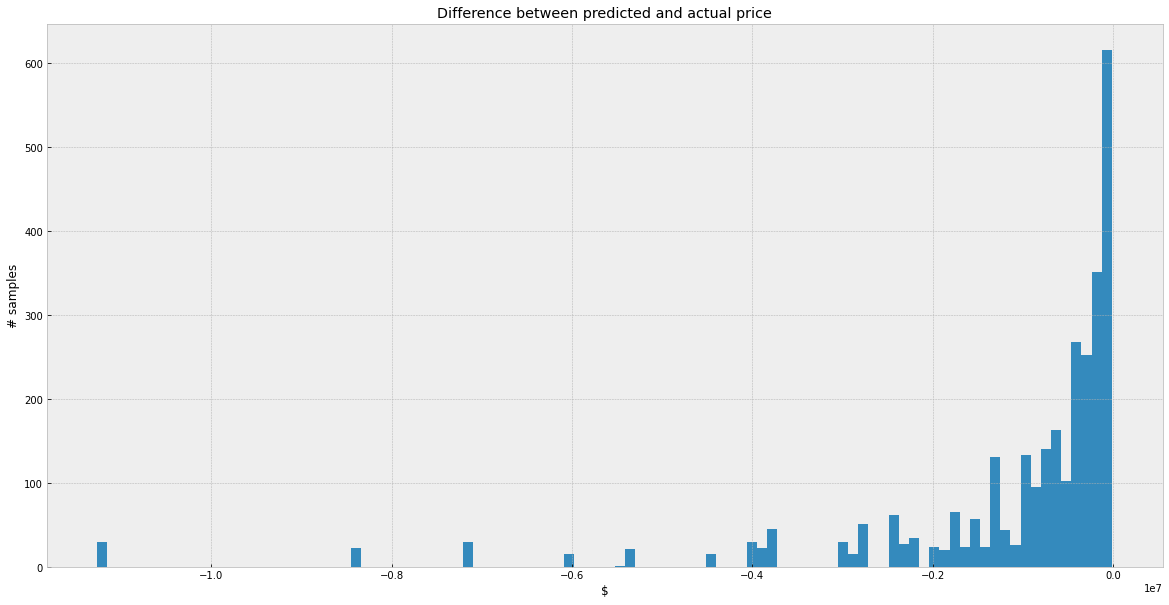

In [24]:
df = pd.DataFrame(Y_val,columns=['price'])

print ("This is the average value we are trying to predict: %d" % df['price'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical,X_val_date])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
print(df.sort_values("abs_diff", ascending=False).head(5))
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

            price         pred  ...      %diff  abs_%diff
637    11265880.0  2451.759033  ... -99.978237  99.978237
7849   11264380.0  2451.759033  ... -99.978234  99.978234
29892  11262862.8  2451.759033  ... -99.978231  99.978231
19070  11262457.8  2451.759033  ... -99.978231  99.978231
15384  11262052.8  2451.759033  ... -99.978230  99.978230

[5 rows x 6 columns]


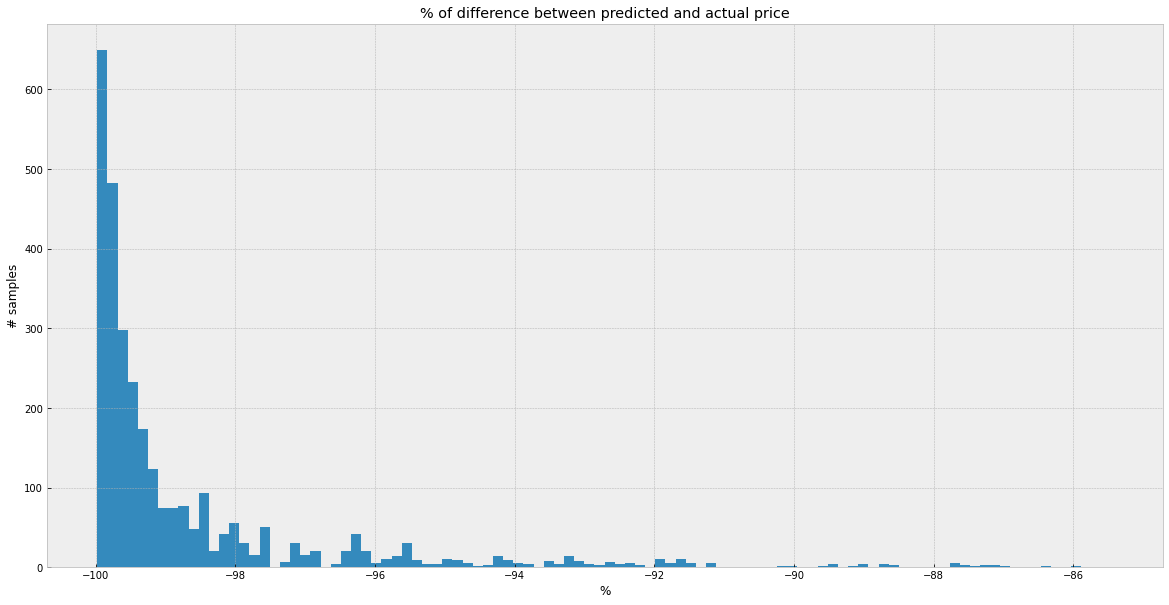

In [25]:
# Sort by the '%diff' field and show the 5 largest proportional mistakes
print(df.sort_values("abs_%diff", ascending=False).head(5))

# Also, plot the histogram
plt.figure(figsize=(20,10))
plt.hist(df['%diff'], bins=100)
plt.xlabel("%")
plt.ylabel("# samples")
_ = plt.title("% of difference between predicted and actual price")

In [31]:
train_ds = pd.concat([X_train_continuous,X_train_categorical,X_train_date], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical,X_val_date], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['price'],
    mode="regression"
)

In [64]:
import scipy as sp

data_row = np.asarray(val_ds.iloc[0])
num_samples = 5000

if sp.sparse.issparse(data_row) and not sp.sparse.isspmatrix_csr(data_row):
    # Preventative code: if sparse, convert to csr format if not in csr format already
    data_row = data_row.tocsr()
data, inverse = exp._LimeTabularExplainer__data_inverse(data_row, num_samples)


In [35]:
data

array([[1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1.],
       [0., 0., 1., 0., 1., 0.]])

In [65]:
import sklearn

distance_metric='euclidean'

if sp.sparse.issparse(data):
    # Note in sparse case we don't subtract mean since data would become dense
    scaled_data = data.multiply(exp.scaler.scale_)
    # Multiplying with csr matrix can return a coo sparse matrix
    if not sp.sparse.isspmatrix_csr(scaled_data):
        scaled_data = scaled_data.tocsr()
else:
    scaled_data = (data - exp.scaler.mean_) / exp.scaler.scale_
distances = sklearn.metrics.pairwise_distances(
        scaled_data,
        scaled_data[0].reshape(1, -1),
        metric=distance_metric
).ravel()

In [40]:

exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
cate_dim = continue_dim + X_train_categorical.shape[1]
input_dim = train_ds.shape[1]

def predict_fn(data1):
    return model.predict([data1[:,0:continue_dim],data1[:,continue_dim:cate_dim],data[:,cate_dim:input_dim]])


In [66]:
yss = predict_fn(inverse)

In [67]:
import copy
from lime.lime_tabular import TableDomainMapper
from lime import explanation

num_features=val_ds.shape[1]
model_regressor=None

# for classification, the model needs to provide a list of tuples - classes
# along with prediction probabilities
if exp.mode == "classification":
    if len(yss.shape) == 1:
        raise NotImplementedError("LIME does not currently support "
                                    "classifier models without probability "
                                    "scores. If this conflicts with your "
                                    "use case, please let us know: "
                                    "https://github.com/datascienceinc/lime/issues/16")
    elif len(yss.shape) == 2:
        if exp.class_names is None:
            exp.class_names = [str(x) for x in range(yss[0].shape[0])]
        else:
            exp.class_names = list(exp.class_names)
        if not np.allclose(yss.sum(axis=1), 1.0):
            warnings.warn("""
            Prediction probabilties do not sum to 1, and
            thus does not constitute a probability space.
            Check that you classifier outputs probabilities
            (Not log probabilities, or actual class predictions).
            """)
    else:
        raise ValueError("Your model outputs "
                            "arrays with {} dimensions".format(len(yss.shape)))

# for regression, the output should be a one-dimensional array of predictions
else:
    try:
        if len(yss.shape) != 1 and len(yss[0].shape) == 1:
            yss = np.array([v[0] for v in yss])
        assert isinstance(yss, np.ndarray) and len(yss.shape) == 1
    except AssertionError:
        raise ValueError("Your model needs to output single-dimensional \
            numpyarrays, not arrays of {} dimensions".format(yss.shape))

    predicted_value = yss[0]
    min_y = min(yss)
    max_y = max(yss)

    # add a dimension to be compatible with downstream machinery
    yss = yss[:, np.newaxis]

feature_names = copy.deepcopy(exp.feature_names)
if feature_names is None:
    feature_names = [str(x) for x in range(data_row.shape[0])]

if sp.sparse.issparse(data_row):
    values = exp.convert_and_round(data_row.data)
    feature_indexes = data_row.indices
else:
    values = exp.convert_and_round(data_row)
    feature_indexes = None

for i in exp.categorical_features:
    if exp.discretizer is not None and i in exp.discretizer.lambdas:
        continue
    name = int(data_row[i])
    if i in exp.categorical_names:
        name = exp.categorical_names[i][name]
    feature_names[i] = '%s=%s' % (feature_names[i], name)
    values[i] = 'True'
categorical_features = exp.categorical_features

discretized_feature_names = None
if exp.discretizer is not None:
    categorical_features = range(data.shape[1])
    discretized_instance = exp.discretizer.discretize(data_row)
    discretized_feature_names = copy.deepcopy(feature_names)
    for f in exp.discretizer.names:
        discretized_feature_names[f] = exp.discretizer.names[f][int(
                discretized_instance[f])]

domain_mapper = TableDomainMapper(feature_names,
                                    values,
                                    scaled_data[0],
                                    categorical_features=categorical_features,
                                    discretized_feature_names=discretized_feature_names,
                                    feature_indexes=feature_indexes)
ret_exp = explanation.Explanation(domain_mapper,
                                    mode=exp.mode,
                                    class_names=exp.class_names)
if exp.mode == "classification":
    ret_exp.predict_proba = yss[0]
    if top_labels:
        labels = np.argsort(yss[0])[-top_labels:]
        ret_exp.top_labels = list(labels)
        ret_exp.top_labels.reverse()
else:
    ret_exp.predicted_value = predicted_value
    ret_exp.min_value = min_y
    ret_exp.max_value = max_y
    labels = [0]
for label in labels:
    (ret_exp.intercept[label],
        ret_exp.local_exp[label],
        ret_exp.score, ret_exp.local_pred) = exp.base.explain_instance_with_data(
            scaled_data,
            yss,
            distances,
            label,
            num_features,
            model_regressor=model_regressor,
            feature_selection=exp.feature_selection)

if exp.mode == "regression":
    ret_exp.intercept[1] = ret_exp.intercept[0]
    ret_exp.local_exp[1] = [x for x in ret_exp.local_exp[0]]
    ret_exp.local_exp[0] = [(i, -1 * j) for i, j in ret_exp.local_exp[1]]



for t in ret_exp.as_map()[0]:
    exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])*10000000000000000000000000000


In [68]:
exp_ana

{'area_mapping': 15.376015755265424,
 'date_mapping': 35.696358754248436,
 'n_rooms': 17.277926410554283,
 'n_rooms_n_rooms': 11.39936375170276,
 'size': 11.784788957694651,
 'type_mapping': 36.34101542808272}

In [60]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
cate_dim = continue_dim + X_train_categorical.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:cate_dim],data[:,cate_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])*10000000000000000000000000000


import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'] )

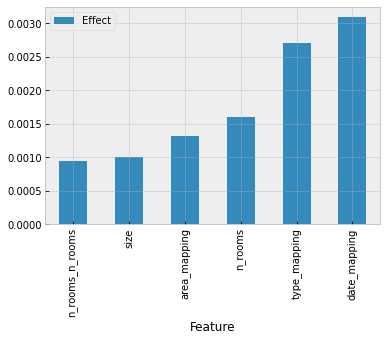

In [61]:
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect',kind='bar')

In [58]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
date,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,2010-05-21,852
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,float64,30000,0,-1.00403e-16,1,-3.88391,-0.689358,-0.0903792,0.708259,4.30213,NaN,NaN,NaN
lamp,float64,30000,0,1.0543e-16,1,-3.6593,-0.680606,-0.000902939,0.6788,4.51712,NaN,NaN,NaN
n_rooms,float64,30000,0,1.52054e-15,1,-1.41576,-0.707562,0.00063738,0.708837,1.41704,NaN,NaN,NaN
ctype,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,intermediate,3852
price,float64,30000,0,1.13951e+06,1.717e+06,16020.6,174436,502696,1.35419e+06,1.12659e+07,NaN,NaN,NaN
size_n_rooms,float64,30000,0,1.23106e-16,1,-1.78064,-0.817624,-0.114881,0.744027,3.81527,NaN,NaN,NaN
size_size,float64,30000,0,2.33831e-17,1,-2.41549,-0.735198,-0.189911,0.650235,6.0304,NaN,NaN,NaN
n_rooms_n_rooms,float64,30000,0,8.1335e-16,1,-1.15615,-0.8089,-0.230153,0.580094,1.62184,NaN,NaN,NaN


In [ ]:
dataset_area_mapping = pd.DataFrame(to_categorical(dataset['area_mapping']-1),columns=['area_' + s for s in AREAS])
dataset_type_mapping = pd.DataFrame(to_categorical(dataset['type_mapping']-1),columns=['type_' + s for s in HOUSE_TYPE])
dataset_date_mapping = pd.DataFrame(to_categorical(dataset['date_mapping']-1),columns=['date_' + str(s) for s in range(dataset['date_mapping'].max())])
dataset = pd.concat([dataset,dataset_area_mapping,dataset_type_mapping,dataset_date_mapping], axis=1)

In [ ]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
date,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243,2010-12-03,609
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,float64,30000,0,-1.00403e-16,1,-3.88391,-0.689358,-0.0903792,0.708259,4.30213,NaN,NaN,NaN
lamp,float64,30000,0,1.0543e-16,1,-3.6593,-0.680606,-0.000902939,0.6788,4.51712,NaN,NaN,NaN
n_rooms,float64,30000,0,1.52054e-15,1,-1.41576,-0.707562,0.00063738,0.708837,1.41704,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
date_238,float32,30000,0,0.0027,0.0518922,0,0,0,0,1,NaN,NaN,NaN
date_239,float32,30000,0,0.000566667,0.0237984,0,0,0,0,1,NaN,NaN,NaN
date_240,float32,30000,0,0.000133333,0.0115464,0,0,0,0,1,NaN,NaN,NaN
date_241,float32,30000,0,0.00176667,0.0419953,0,0,0,0,1,NaN,NaN,NaN


In [ ]:
dataset

,date,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,date_mapping,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible,date_0,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,date_10,date_11,date_12,date_13,date_14,date_15,...,date_203,date_204,date_205,date_206,date_207,date_208,date_209,date_210,date_211,date_212,date_213,date_214,date_215,date_216,date_217,date_218,date_219,date_220,date_221,date_222,date_223,date_224,date_225,date_226,date_227,date_228,date_229,date_230,date_231,date_232,date_233,date_234,date_235,date_236,date_237,date_238,date_239,date_240,date_241,date_242
0,2010-04-13,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094,1,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-04-13,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840,2,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-04-13,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840,1,2,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-04-13,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149,2,3,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-04-13,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900,2,4,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2010-12-11,Old North,1.107578,0.678800,0.708837,intermediate,648407.8,1.212522,1.118778,0.580094,2,5,243,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29996,2010-12-11,Florentine,-0.090379,0.978669,-1.415762,intermediate,29374.0,-1.286119,-0.189911,-1.156149,1,5,243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
29997,2010-12-11,Florentine,0.708259,0.998660,0.708837,standard,505119.2,1.004302,0.650235,0.580094,1,3,243,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
#  추가 파생변수 생성
dataset_size_area_mapping = dataset[['area_' + s for s in AREAS]].multiply(dataset['size'], axis=0)
dataset_n_rooms_area_mapping = dataset[['area_' + s for s in AREAS]].multiply(dataset['n_rooms'], axis=0)
dataset_size_area_mapping.rename(columns={'area_' + s:'size_area_'+s for s in AREAS}, inplace=True)
dataset_n_rooms_area_mapping.rename(columns={'area_' + s:'n_rooms_area_'+s for s in AREAS}, inplace=True)

dataset_size_type_mapping = dataset[['type_' + s for s in HOUSE_TYPE]].multiply(dataset['size'], axis=0)
dataset_n_rooms_type_mapping = dataset[['type_' + s for s in HOUSE_TYPE]].multiply(dataset['n_rooms'], axis=0)
dataset_size_type_mapping.rename(columns={'type_' + s:'size_type_'+s for s in HOUSE_TYPE}, inplace=True)
dataset_n_rooms_type_mapping.rename(columns={'type_' + s:'n_rooms_type_'+s for s in HOUSE_TYPE}, inplace=True)

In [ ]:
dataset = pd.concat([dataset,dataset_size_area_mapping,dataset_n_rooms_area_mapping,dataset_size_type_mapping,dataset_n_rooms_type_mapping], axis=1)

In [ ]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
date,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,243,2010-12-03,609
area,object,30000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Mercaz,10037
size,float64,30000,0,-1.00403e-16,1,-3.88391,-0.689358,-0.0903792,0.708259,4.30213,NaN,NaN,NaN
lamp,float64,30000,0,1.0543e-16,1,-3.6593,-0.680606,-0.000902939,0.6788,4.51712,NaN,NaN,NaN
n_rooms,float64,30000,0,1.52054e-15,1,-1.41576,-0.707562,0.00063738,0.708837,1.41704,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
n_rooms_type_standard,float64,30000,0,-0.00322619,0.351288,-1.41576,-0,-0,0,1.41704,NaN,NaN,NaN
n_rooms_type_fullsize,float64,30000,0,-0.000177834,0.35681,-1.41576,0,0,0,1.41704,NaN,NaN,NaN
n_rooms_type_premium,float64,30000,0,0.00126153,0.354106,-1.41576,0,-0,0,1.41704,NaN,NaN,NaN
n_rooms_type_luxury,float64,30000,0,0.00151944,0.35681,-1.41576,-0,0,0,1.41704,NaN,NaN,NaN


In [ ]:
dataset

,date,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,date_mapping,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible,date_0,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,date_10,date_11,date_12,date_13,date_14,date_15,...,date_225,date_226,date_227,date_228,date_229,date_230,date_231,date_232,date_233,date_234,date_235,date_236,date_237,date_238,date_239,date_240,date_241,date_242,size_area_Mercaz,size_area_Old North,size_area_Florentine,n_rooms_area_Mercaz,n_rooms_area_Old North,n_rooms_area_Florentine,size_type_economy,size_type_compact,size_type_intermediate,size_type_standard,size_type_fullsize,size_type_premium,size_type_luxury,size_type_convertible,n_rooms_type_economy,n_rooms_type_compact,n_rooms_type_intermediate,n_rooms_type_standard,n_rooms_type_fullsize,n_rooms_type_premium,n_rooms_type_luxury,n_rooms_type_convertible
0,2010-04-13,Florentine,-0.889017,-0.420719,0.708837,compact,304480.0,0.171421,-0.900804,0.580094,1,1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.889017,-0.000000,-0.000000,0.708837,0.000000,0.000000,-0.889017,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,0.708837,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,2010-04-13,Old North,-0.290039,0.318957,1.417037,economy,607930.0,1.082384,-0.379752,1.621840,2,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.290039,-0.000000,0.000000,1.417037,0.000000,-0.000000,-0.290039,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,0.000000,1.417037,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,2010-04-13,Florentine,2.105876,2.178144,1.417037,economy,382930.0,2.644035,2.431507,1.621840,1,2,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.105876,0.000000,0.000000,1.417037,0.000000,0.000000,0.000000,2.105876,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.417037,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,2010-04-13,Old North,-0.689358,1.098616,-1.415762,standard,57230.0,-1.364201,-0.735198,-1.156149,2,3,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.689358,-0.000000,-0.000000,-1.415762,-0.000000,-0.000000,-0.000000,-0.689358,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-1.415762,-0.000000,-0.000000,-0.000000,-0.0,-0.0
4,2010-04-13,Old North,-0.689358,-2.020020,-0.707562,fullsize,247230.0,-0.817624,-0.735198,-0.808900,2,4,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.689358,-0.000000,-0.000000,-0.707562,-0.000000,-0.000000,-0.000000,-0.000000,-0.689358,-0.000000,-0.000000,-0.0,-0.0,-0.000000,-0.000000,-0.000000,-0.707562,-0.000000,-0.000000,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,2010-12-11,Old North,1.107578,0.678800,0.708837,intermediate,648407.8,1.212522,1.118778,0.580094,2,5,243,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# trainset과 validationset 나누고... 기타 정리

columns = list(dataset.columns)
for a in ['date','area','ctype','lamp','price','size_n_rooms','size_size']:
  columns.remove(a)

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[columns],
    dataset['price'], test_size=0.1, random_state=0)

columns.remove('area_mapping')
columns.remove('type_mapping')
columns.remove('date_mapping')

X_train_continuous = X_train_org[columns]
X_train_categorical = X_train_org[['area_mapping','type_mapping']]
X_train_date = X_train_org[['date_mapping']]

X_val_continuous = X_val_org[columns]
X_val_categorical = X_val_org[['area_mapping','type_mapping']]
X_val_date = X_val_org[['date_mapping']]

In [ ]:
# Define the embedding input
cate_input = Input(shape=(2,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 24*3


# Let’s define the embedding layer and flatten it
cate_embedings = Embedding(output_dim=embeddings_output, input_dim=100)(cate_input)
cate_embedings = keras.layers.Reshape((embeddings_output*2,))(cate_embedings)



In [ ]:
date_input = Input(shape=(1,), dtype='int32') 

# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 40
# Let’s define the embedding layer and flatten it
date_embedings = Embedding(output_dim=embeddings_output, input_dim=X_train_date['date_mapping'].max()+1)(date_input)
date_embedings = keras.layers.Reshape((embeddings_output*1,))(date_embedings)

In [ ]:
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, cate_embedings,date_embedings])

print(all_input)

Tensor("concatenate_2/concat:0", shape=(None, 463), dtype=float32)


In [ ]:
 def mean_squared_error(y_true, y_pred):
     return K.mean(K.square(y_pred - y_true), axis=-1)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1,)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, cate_input,date_input], outputs=predictions)
model.compile(loss=mean_squared_error, optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_100_acc,soft_300_acc,r2])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2, 72)        7200        input_4[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 40)        9760        input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
epochs = 1000

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous,X_train_categorical,X_train_date], Y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_50], verbose=0,
          validation_data=([X_val_continuous,X_val_categorical,X_val_date], Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 50 - {'val_loss': 9386530.585333332, 'val_soft_100_acc': 0.087379090487957, 'val_soft_300_acc': 0.2550223171710968, 'val_r2': 0.9999969601631165, 'loss': 1218908.3106296295, 'soft_100_acc': 0.10380875, 'soft_300_acc': 0.30155015, 'r2': 0.99999994}
Epoch: 100 - {'val_loss': 8287584.816333333, 'val_soft_100_acc': 0.1062592938542366, 'val_soft_300_acc': 0.2955729067325592, 'val_r2': 0.9999971985816956, 'loss': 769987.7065185185, 'soft_100_acc': 0.12425207, 'soft_300_acc': 0.3510318, 'r2': 0.99999994}
Epoch: 150 - {'val_loss': 7988963.475333333, 'val_soft_100_acc': 0.114815853536129, 'val_soft_300_acc': 0.3139880895614624, 'val_r2': 0.9999974370002747, 'loss': 625844.3191481482, 'soft_100_acc': 0.13324447, 'soft_300_acc': 0.38254836, 'r2': 0.99999994}
Epoch: 200 - {'val_loss': 7791779.851666667, 'val_soft_100_acc': 0.1223958358168602, 'val_soft_300_acc': 0.3246372640132904, 'val_r2': 0.9999975562095642, 'loss': 551940.5329259259, 'soft_100_acc': 0.14010663, 'soft_300_acc': 0.4012465

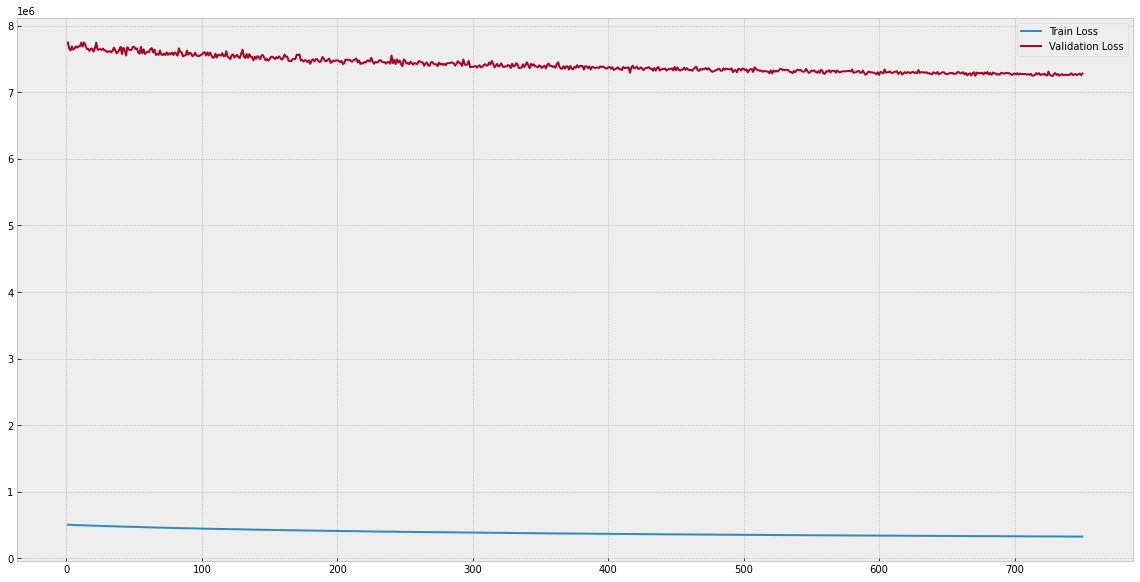

In [ ]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1127023
The mean is very close to 0 (-100.54) with std. 2697.17.


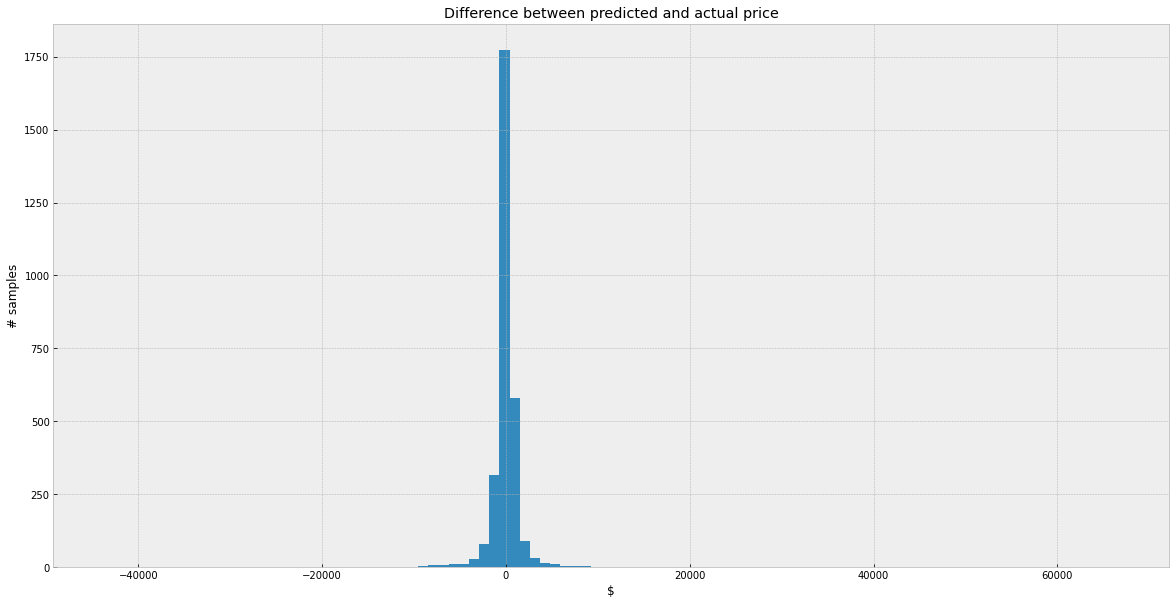

,pred,diff,abs_diff,%diff,abs_%diff,date,area,size,lamp,n_rooms,ctype,price,size_n_rooms,size_size,n_rooms_n_rooms,area_mapping,type_mapping,date_mapping,area_Mercaz,area_Old North,area_Florentine,type_economy,type_compact,type_intermediate,type_standard,type_fullsize,type_premium,type_luxury,type_convertible,date_0,date_1,date_2,date_3,date_4,date_5,date_6,date_7,date_8,date_9,date_10,...,date_225,date_226,date_227,date_228,date_229,date_230,date_231,date_232,date_233,date_234,date_235,date_236,date_237,date_238,date_239,date_240,date_241,date_242,size_area_Mercaz,size_area_Old North,size_area_Florentine,n_rooms_area_Mercaz,n_rooms_area_Old North,n_rooms_area_Florentine,size_type_economy,size_type_compact,size_type_intermediate,size_type_standard,size_type_fullsize,size_type_premium,size_type_luxury,size_type_convertible,n_rooms_type_economy,n_rooms_type_compact,n_rooms_type_intermediate,n_rooms_type_standard,n_rooms_type_fullsize,n_rooms_type_premium,n_rooms_type_luxury,n_rooms_type_convertible
20086,7.275848e+06,66630.700,66630.700,0.924243,0.924243,2010-09-27,Mercaz,-0.290039,0.039080,0.708837,luxury,7209217.8,0.483752,-0.379752,0.580094,3,6,168,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.290039,0.0,0.0,0.708837,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.290039,-0.000000,-0.0,0.000000,0.0,0.0,0.0,0.0,0.708837,0.000000,0.0
21549,7.166284e+06,-43743.300,43743.300,-0.606701,0.606701,2010-10-09,Mercaz,0.109280,-0.840536,0.708837,luxury,7210027.8,0.691972,0.008008,0.580094,3,6,180,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109280,0.0,0.0,0.708837,0.000000,0.0,0.0,0.0,0.0,0.109280,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.708837,0.000000,0.0
8156,1.122231e+07,-38933.800,38933.800,-0.345733,0.345733,2010-06-22,Mercaz,0.708259,0.199010,1.417037,luxury,11261242.8,1.733072,0.650235,1.621840,3,6,71,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.708259,0.0,0.0,1.417037,0.000000,0.0,0.0,0.0,0.0,0.708259,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.417037,0.000000,0.0
18518,5.374043e+06,-37604.800,37604.800,-0.694886,0.694886,2010-09-16,Mercaz,0.907919,0.578844,0.708837,convertible,5411647.8,1.108412,0.880468,0.580094,3,7,157,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.907919,0.0,0.0,0.708837,0.000000,0.0,0.0,0.0,0.0,0.000000,0.907919,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.708837,0.0
23313,3.010379e+06,-35123.800,35123.800,-1.153301,1.153301,2010-10-23,Mercaz,-0.889017,0.438905,0.000637,convertible,3045502.8,-0.349129,-0.900804,-0.230153,3,7,194,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.889017,0.0,0.0,0.000637,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.889017,-0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000637,0.0
6476,1.451616e+06,33313.575,33313.575,2.348834,2.348834,2010-06-07,Mercaz,1.107578,0.898704,1.417037,compact,1418302.8,1.993347,1.118778,1.621840,3,1,56,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.107578,0.0,0.0,1.417037,1.107578,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.417037,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
6255,7.184133e+06,-29247.000,29247.000,-0.405455,0.405455,2010-06-02,Mercaz,0.508599,-0.160833,0.708837,luxury,7213380.0,0.900192,0.428081,0.580094,3,6,51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,

In [ ]:
df = pd.DataFrame(Y_val,columns=['price'])

print ("This is the average value we are trying to predict: %d" % df['price'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical,X_val_date])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['price'],inplace=True)
b = a.join(dataset)
b.head(10)

In [ ]:
train_ds = pd.concat([X_train_continuous,X_train_categorical,X_train_date], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical,X_val_date], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['price'],
    mode="regression"
)

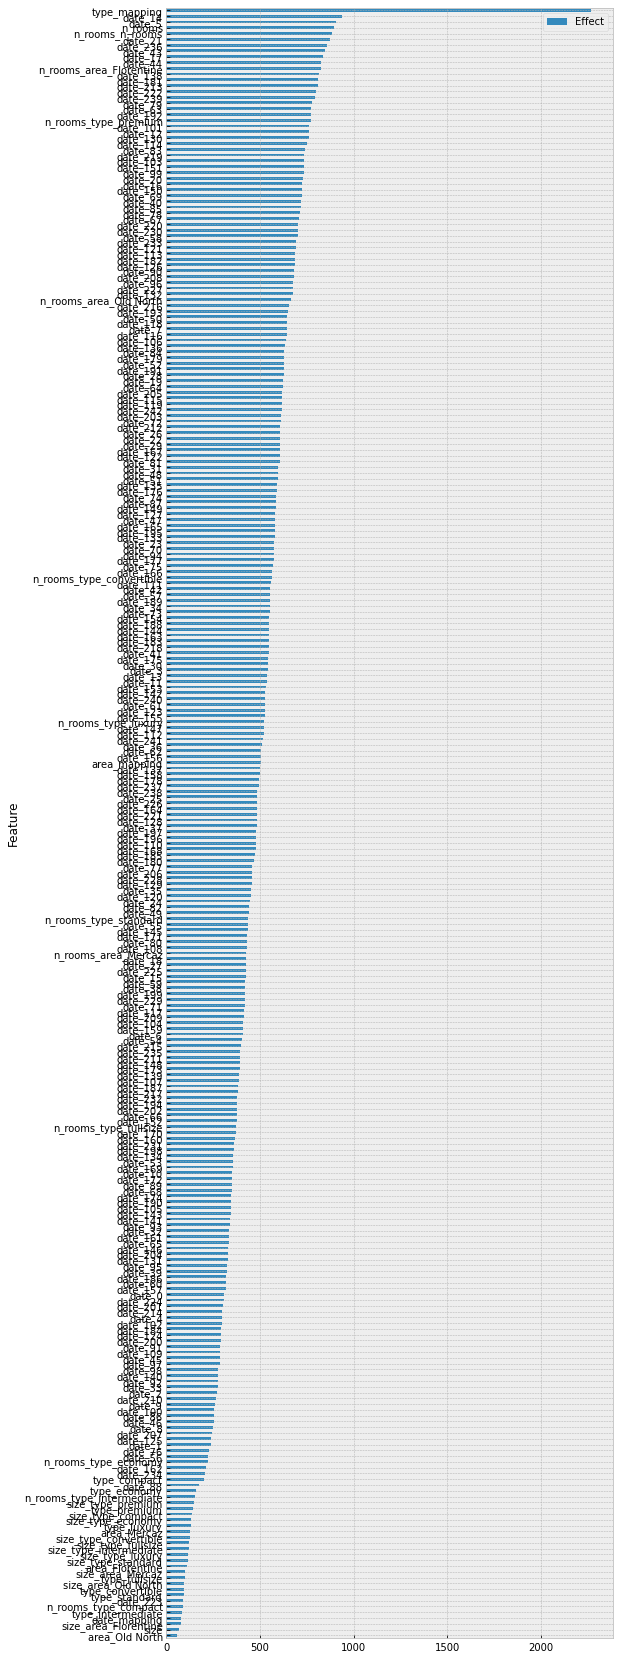

,Feature,Effect
0,area_Old North,55.673944
1,size,70.163735
2,size_area_Florentine,76.356871
3,date_mapping,80.684468
4,type_intermediate,84.498019
...,...,...
277,n_rooms_n_rooms,884.056843
278,n_rooms,893.180304
279,date_5,906.381241
280,date_14,939.135369


In [ ]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
cate_dim = continue_dim + X_train_categorical.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:cate_dim],data[:,cate_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 30),kind='barh')
plt.show()
effect_result_table